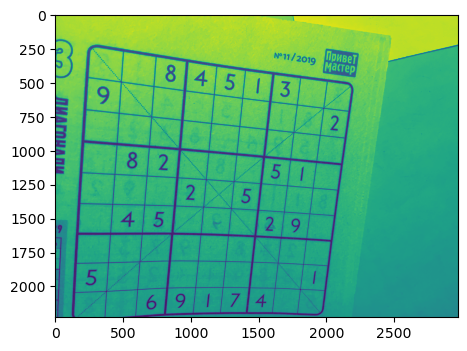

In [38]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import cv2 as cv
from skimage import io
from skimage.io import imread
from skimage.feature import canny
from scipy.signal import convolve2d
from skimage.measure import label
from skimage import morphology
from sklearn.cluster import AgglomerativeClustering
import tensorflow
#import torch

#img = cv.imread("train_0.jpg")

#img = cv.imread("train_0.jpg")#ok works well (also with train_5 param)
#img = cv.imread("train_1.jpg") #problem - con closed contour
#img = cv.imread("train_2.jpg", 0) / 255 #two images - need to account for that - otherwise works (also with train_5 param)
#img = cv.imread("train_3.jpg")# ok works well (also with train_5 param)
#img = cv.imread("train_4.jpg") # ok works well (also with train_5 param)
#img = cv.imread("train_5.jpg") # worked with sigma=0.3, low_threshold=0.3*np.mean(img),high_threshold=1*np.mean(img))
#img = cv.imread("train_6.jpg", 0) / 255 # worked well with parameters as train_5 (just I did not change)
#img = cv.imread("train_7.jpg", 0) / 255  # worked well with parameters as train_5 (just I did not change)
#img = cv.imread("train_8.jpg", 0) / 255 # worked well with parameters as train_5 (just I did not change)
img = cv.imread("test_4.jpg")
#img = img[..., ::-1] #it' the same
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.figure(dpi=100)
plt.imshow(img)

Part 1: Find tables 

- Step 1: find some keypoints (Otsu thresholding, edges, Hough lines, corners of 9x9 table, etc.)
- Step 2: find 9x9 tables, estimate Sudoku-ness of each (Hough lines, regular structures, etc.)
- Step 3: apply Projective Transform for every found table

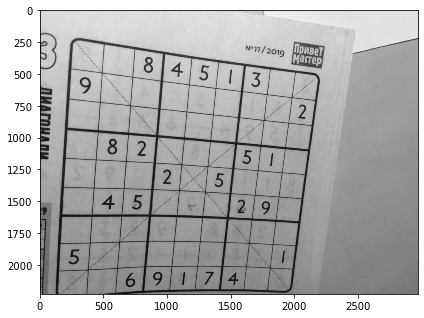

In [15]:
blurred = cv.GaussianBlur(img, (7, 7), 3)
plt.figure(figsize=(6, 6))
io.imshow(blurred)

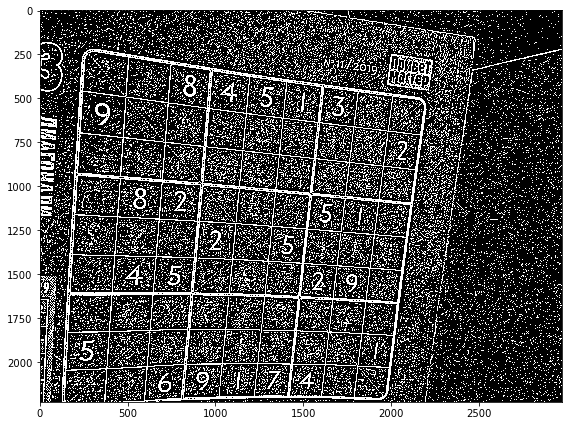

In [28]:
thresh = cv.adaptiveThreshold(blurred, 255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 15, 1)
thresh = cv.bitwise_not(thresh)
plt.figure(figsize=(8, 8))
io.imshow(thresh)

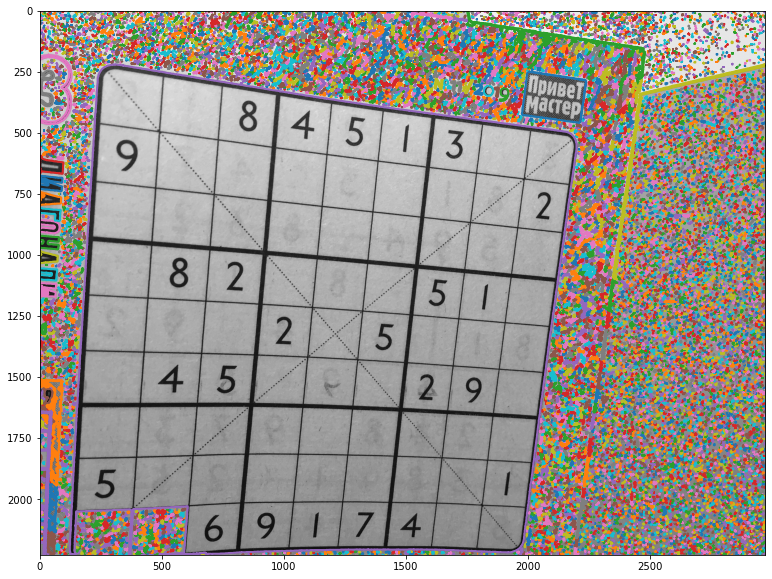

In [29]:
#import imutils
#edges = (edges).astype(np.uint8)
ext_contours = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]
#ext_contours = imutils.grab_contours(ext_contours)
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(img, cmap=plt.cm.gray)

for n, contour in enumerate(ext_contours):
    contour = np.array(contour).squeeze() # we need to remove one dim, se below
    if contour.ndim > 1:
        ax.plot(contour[:, 0], contour[:, 1], linewidth=2)

(2271, 1, 2)
(2271, 2)


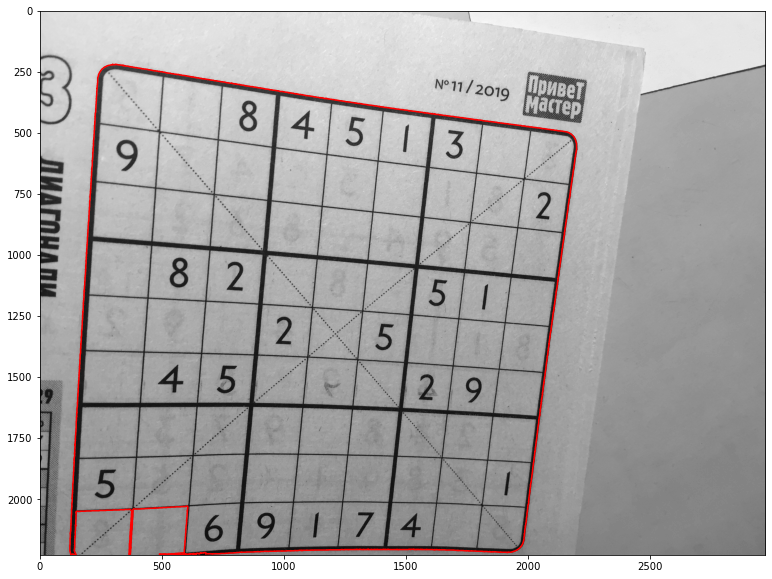

In [30]:
contour = max(ext_contours, key= lambda x : cv.contourArea(x))

# we need to remove one unnecessary dimension
print(contour.shape)
contour = contour.squeeze()
print(contour.shape)
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(contour[:, 0], contour[:,  1], 'r')

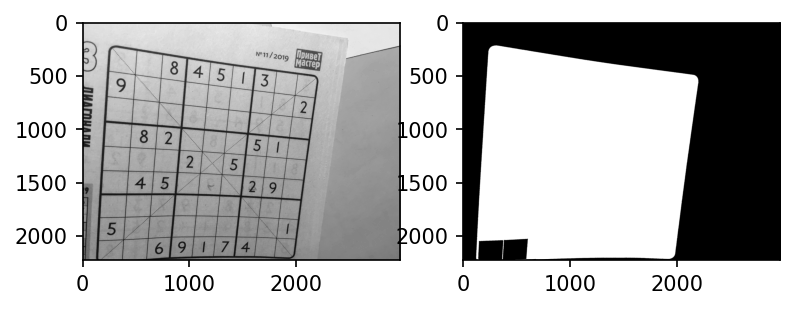

In [31]:
image = np.zeros(img.shape)
fill = cv.fillPoly(image, [contour], (255, 255, 255))


plt.figure(dpi=150)
plt.subplot(1,2,1)   
# plt.axis('off')
plt.imshow(img, cmap=plt.cm.gray)
plt.subplot(1,2,2)     
# plt.axis('off')
plt.imshow(fill, cmap=plt.cm.gray)

# Solve the sudoku

Part 2: Recognize digits

Step 4: divide table into separate cells (optionally: remove table artifacts)
Step 5: build digit classifier on MNIST: feature extractor (e.g. HoG) + classifier (SVM, Random Forest, NN, etc.)


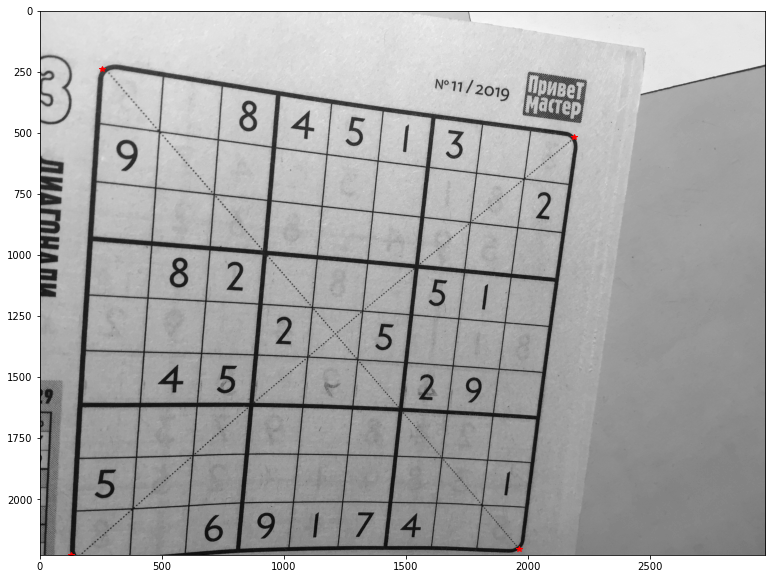

In [32]:
epsilon = 0.05 * cv.arcLength(contour, True)
corners = cv.approxPolyDP(contour, epsilon, True).squeeze()
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(corners[:, 0], corners[:, 1], '*r')

In [34]:
#if len(corners)>4:
    
corners

array([[ 256,  237],
       [ 127, 2227],
       [1963, 2202],
       [2187,  515]], dtype=int32)

In [22]:
dis = []
a = [0,0]
for i in range(4):
    dist = np.linalg.norm(a-corners[i])
    dis.append(dist)

ff = np.argmin(dis)
tt = np.argmax(dis)
print(corners)

for i in range(4):
    if i!=ff and i!=tt:
        if corners[i][0]<corners[ff][0]:
            tw = i
        if corners[i][0]>corners[tt][0]:
            fr = i
cc =[]
for i in range(4):
    if i==0:
        cc.append(list(corners[ff]))
    if i==1:
        cc.append(list(corners[tw]))
    if i==2:
        cc.append(list(corners[tt]))
    if i==3:
        cc.append(list(corners[fr]))
    

corners = np.array(cc)
print(corners.shape)

[[ 255  238]
 [ 127 2227]
 [ 158 1709]
 [ 141 2227]
 [1963 2202]
 [2186  514]]
(4, 2)


first


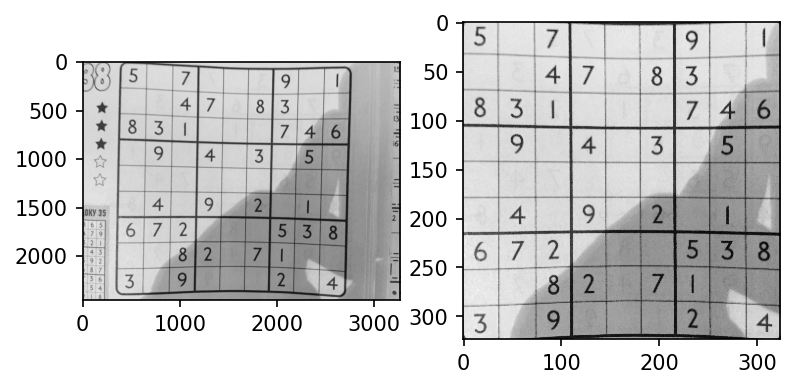

In [13]:
from skimage.transform import ProjectiveTransform, warp
points_current = corners
size = 324
if corners[3][1] < corners[2][1]:
    points_desired = np.array([[0, 0],[0, size], [size, size],[size, 0]])   
    print('first')
else:
    points_desired = np.array([[size, 0],[0, 0],[0, size], [size, size]])
    print('second')
tform = ProjectiveTransform()
tform.estimate(points_desired, points_current)
image_warped = warp(img, tform)[:size, :size]
#plt.figure(figsize=(13 ,13))


plt.figure(dpi=150)
plt.subplot(1,2,1)   
# plt.axis('off')
plt.imshow(img, cmap=plt.cm.gray)
plt.subplot(1,2,2)     
# plt.axis('off')
plt.imshow(image_warped, cmap=plt.cm.gray)

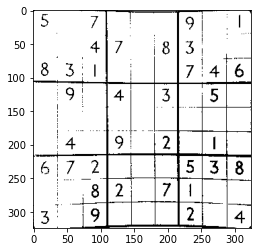

In [116]:
ret, bw_img = cv.threshold(image_warped*255,100,255,cv.THRESH_BINARY)
plt.imshow(bw_img, cmap=plt.cm.gray)

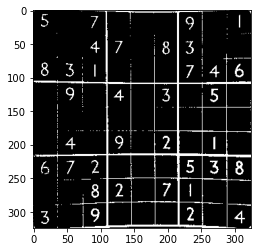

In [37]:
bw_img = (255-bw_img)
plt.imshow(bw_img, cmap=plt.cm.gray)

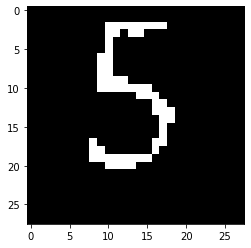

In [38]:
from skimage.transform import rescale

cell_size = int(image_warped.shape[0]/9)
cells = []
for i in range(9):
    for j in range(9):
        c = bw_img[cell_size*i+4:cell_size*(i+1)-4,cell_size*j+4:cell_size*(j+1)-4]
        #c_scaled = rescale(img, 0.3, multichannel=False)
        cells.append(c)
        
cells = np.array(cells)
cells.shape
#c = image_warped[cell*7:cell*8,0:cell]
plt.imshow(cells[0], cmap=plt.cm.gray)


In [33]:
from keras.datasets import mnist
from keras.layers import Dense, Flatten, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from keras.utils import to_categorical


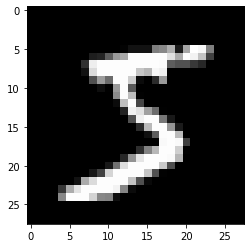

5


In [19]:
from mnist.loader import MNIST
save_model_path = "."
MNIST_CELL_SIZE = 28

mnist_data_path = '.'
mnist_data = MNIST(mnist_data_path)
mnist_data.gz = True

X_train, y_train = mnist_data.load_training()
X_test, y_test = mnist_data.load_testing()


X_train = np.uint8([np.reshape(im, (MNIST_CELL_SIZE,) * 2) for im in X_train])
X_test = np.uint8([np.reshape(im, (MNIST_CELL_SIZE,) * 2) for im in X_test])
y_train, y_test = np.int16(y_train), np.int16(y_test)


plt.imshow(X_train[0], cmap="gray")
plt.show()
print (y_train[0])

In [20]:
## Checking out the shapes involved in dataset
print ("Shape of X_train: {}".format(X_train.shape))
print ("Shape of y_train: {}".format(y_train.shape))
print ("Shape of X_test: {}".format(X_test.shape))
print ("Shape of y_test: {}".format(y_test.shape))

Shape of X_train: (60000, 28, 28)
Shape of y_train: (60000,)
Shape of X_test: (10000, 28, 28)
Shape of y_test: (10000,)


In [21]:
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
print ("Shape of X_train: {}".format(X_train.shape))
print ("Shape of y_train: {}".format(y_train.shape))
print ("Shape of X_test: {}".format(X_test.shape))
print ("Shape of y_test: {}".format(y_test.shape))

Shape of X_train: (60000, 28, 28, 1)
Shape of y_train: (60000,)
Shape of X_test: (10000, 28, 28, 1)
Shape of y_test: (10000,)


In [22]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [60]:
## Declare the model
model = Sequential()

## Declare the layers
layer_1 = Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1))
layer_2 = Conv2D(64, kernel_size=3, activation='relu', dilation_rate=4)
layer_3 = Flatten()
layer_4 = Dense(10, activation='softmax')

## Add the layers to the model
model.add(layer_1)
model.add(layer_2)
model.add(layer_3)
model.add(layer_4)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
# compile model
opt = tensorflow.keras.optimizers.SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Epoch 1/5
1875/1875 [==============================] - 55s 30ms/step - loss: 0.3973 - accuracy: 0.9531 - val_loss: 0.0821 - val_accuracy: 0.9752
Epoch 2/5
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0614 - accuracy: 0.9829 - val_loss: 0.0838 - val_accuracy: 0.9748
Epoch 3/5
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0494 - accuracy: 0.9858 - val_loss: 0.0807 - val_accuracy: 0.9780
Epoch 4/5
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0410 - accuracy: 0.9883 - val_loss: 0.0991 - val_accuracy: 0.9770
Epoch 5/5
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0388 - accuracy: 0.9898 - val_loss: 0.1061 - val_accuracy: 0.9826


In [57]:
model.save('C:/Users/admin/Desktop/Skoltech/Intro to CV/HW2/mod4.h5')

In [105]:
torch.save({'state_dict': model.state_dict(),'optimizer' : optimizer.state_dict(),}, 'filename.pth.tar')

AttributeError: 'Sequential' object has no attribute 'state_dict'

In [233]:
# serialize to JSON
json_file = model.to_json()
with open('cnn.joblib', "w") as file:
    file.write(json_file)
# serialize weights to HDF5
#model.save_weights(h5_file)



---------------------------------------


=========PREDICTION============ 




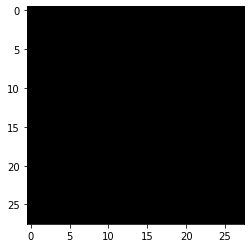



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




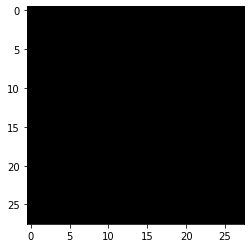



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




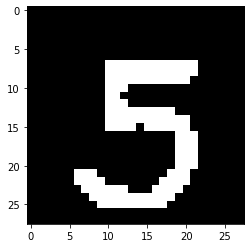



Final Output: 5

Prediction (Softmax) from the neural network:

 [[8.1054131e-17 2.5915213e-20 2.6034910e-20 4.7936100e-11 4.7265497e-16
  1.0000000e+00 7.9327026e-18 3.2920838e-15 1.0814286e-12 4.5026445e-16]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




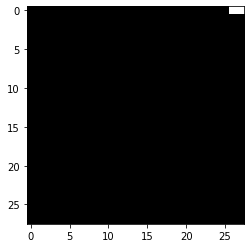



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.03428817 0.18211143 0.09820491 0.1177377  0.06653631 0.14173894
  0.18017346 0.02946934 0.10202029 0.04771936]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




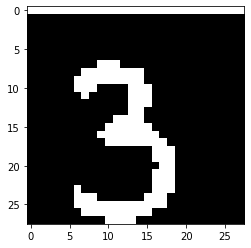



Final Output: 3

Prediction (Softmax) from the neural network:

 [[2.1583802e-17 5.0454565e-07 6.2609484e-10 9.9999952e-01 1.8860753e-15
  1.6947672e-15 2.0954903e-15 8.3485500e-17 3.9195821e-12 1.7959319e-17]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




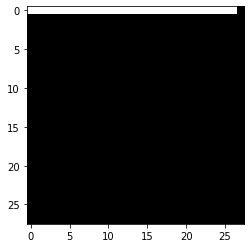



Final Output: 1

Prediction (Softmax) from the neural network:

 [[3.64915505e-02 9.18059409e-01 1.21329875e-04 2.94530089e-03
  1.80205014e-02 1.84812336e-06 2.03671679e-02 6.03485983e-10
  3.99204995e-03 8.66057576e-07]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




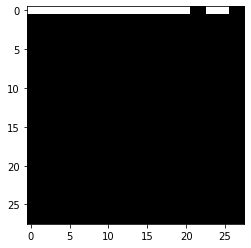



Final Output: 1

Prediction (Softmax) from the neural network:

 [[5.1055714e-02 9.2177612e-01 7.8829842e-05 1.8579678e-03 1.1520630e-02
  7.5640896e-06 7.6099164e-03 3.3981506e-10 6.0922480e-03 1.0984959e-06]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




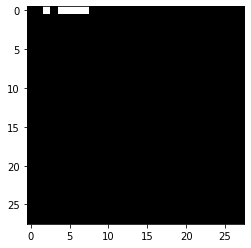



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.00945891 0.46220443 0.00859402 0.33468476 0.00108575 0.01352654
  0.08334305 0.0014116  0.07387044 0.01182051]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




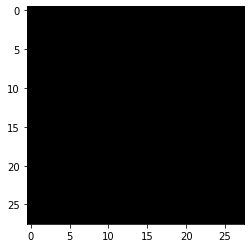



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




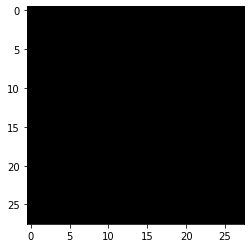



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




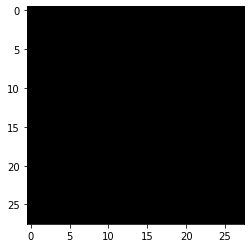



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




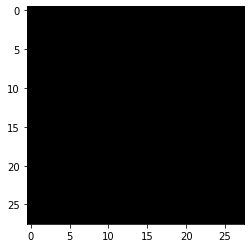



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




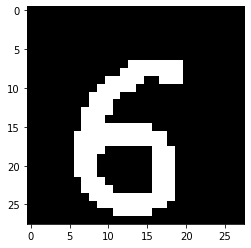



Final Output: 5

Prediction (Softmax) from the neural network:

 [[1.2644952e-04 3.5026911e-16 1.1835162e-06 3.6560605e-06 2.0370268e-13
  9.5295137e-01 2.3031684e-05 2.1048785e-09 4.6893943e-02 3.5413302e-07]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




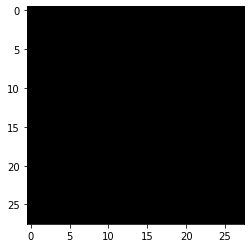



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




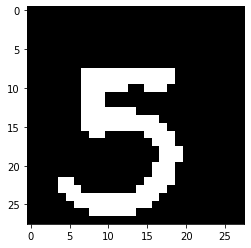



Final Output: 3

Prediction (Softmax) from the neural network:

 [[8.37414126e-15 5.68940342e-15 1.58426027e-14 6.75498962e-01
  7.91664304e-12 3.24501038e-01 1.36038811e-14 1.43783945e-08
  9.55506119e-10 3.74815699e-11]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




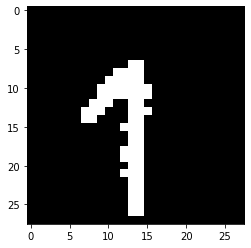



Final Output: 9

Prediction (Softmax) from the neural network:

 [[3.6930019e-04 6.3882008e-02 1.8152163e-03 3.4064555e-01 6.0348208e-05
  1.5887836e-03 2.3104574e-06 9.5966533e-02 2.3324571e-04 4.9543661e-01]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




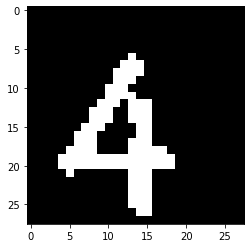



Final Output: 0

Prediction (Softmax) from the neural network:

 [[3.0337796e-01 2.7097705e-01 6.2947453e-04 1.3227581e-06 1.4291778e-01
  5.3756516e-02 2.2809884e-01 8.8213056e-07 2.4002350e-04 2.7206161e-07]]


Hard-maxed form of the prediction: 

 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




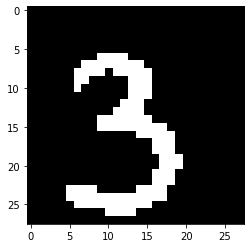



Final Output: 3

Prediction (Softmax) from the neural network:

 [[3.0867592e-21 2.4675857e-15 6.4142364e-16 1.0000000e+00 1.5687485e-17
  3.3803051e-19 4.1026080e-19 1.0950394e-14 6.9129778e-20 3.6085210e-16]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




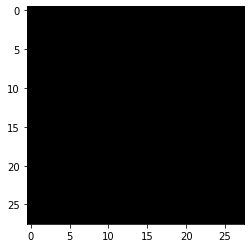



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




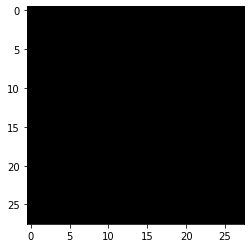



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




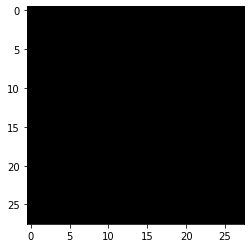



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




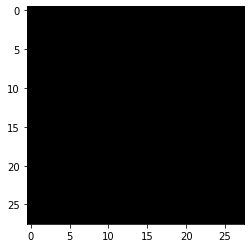



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




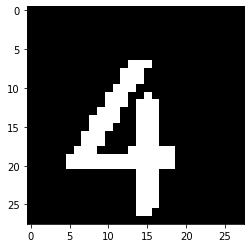



Final Output: 6

Prediction (Softmax) from the neural network:

 [[1.1065770e-01 2.7329605e-03 2.5507016e-02 5.3604759e-05 1.1977051e-01
  1.0673785e-02 7.3050576e-01 1.5003089e-06 9.1194073e-05 5.9922227e-06]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




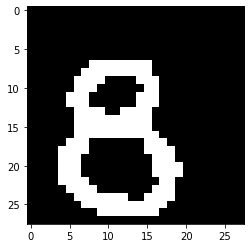



Final Output: 8

Prediction (Softmax) from the neural network:

 [[5.3730247e-07 8.6924654e-09 3.1301493e-04 6.1432607e-02 1.8446623e-11
  3.1681852e-06 4.0600699e-15 1.2946500e-08 9.3825001e-01 6.3402325e-07]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




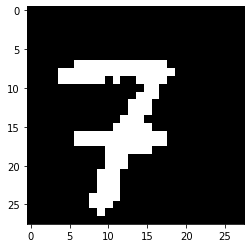



Final Output: 3

Prediction (Softmax) from the neural network:

 [[1.8734183e-13 2.8985292e-07 1.1939883e-08 8.7111485e-01 1.8024600e-13
  1.8849570e-12 2.6183787e-14 1.2888481e-01 1.4327954e-10 1.4681678e-09]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




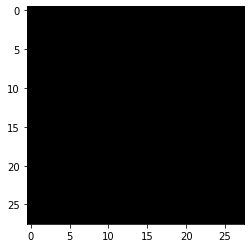



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




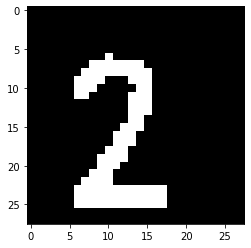



Final Output: 2

Prediction (Softmax) from the neural network:

 [[1.7317399e-12 2.6566431e-06 9.9999368e-01 7.2255449e-07 3.9545537e-15
  1.6711047e-14 3.6460254e-15 2.9634002e-06 2.2686551e-10 3.3464496e-12]]


Hard-maxed form of the prediction: 

 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




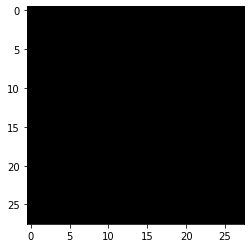



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




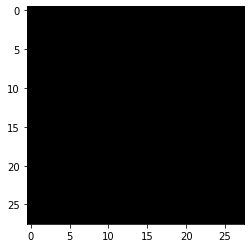



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




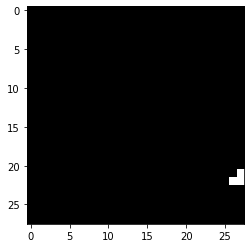



Final Output: 4

Prediction (Softmax) from the neural network:

 [[0.09923977 0.09824567 0.02713845 0.03699635 0.56661046 0.09861147
  0.03953819 0.01454353 0.0102268  0.00884933]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




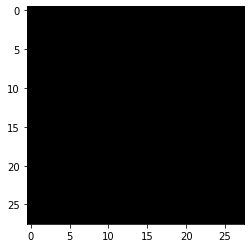



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




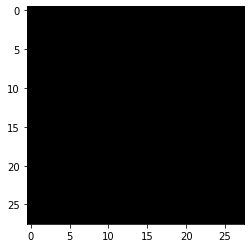



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




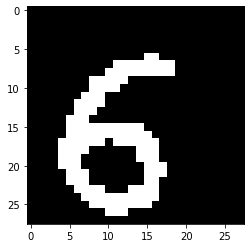



Final Output: 5

Prediction (Softmax) from the neural network:

 [[1.35336395e-05 7.89796644e-15 5.39527264e-07 3.58397892e-06
  4.62692547e-13 9.99981642e-01 2.50043625e-10 2.50461023e-12
  7.42221459e-07 1.42662615e-09]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




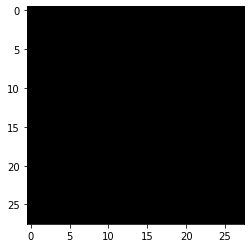



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




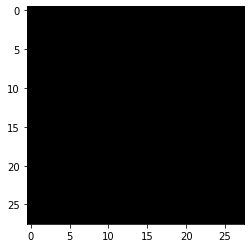



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




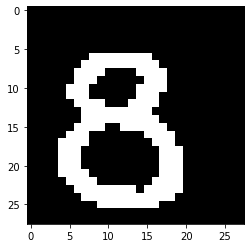



Final Output: 8

Prediction (Softmax) from the neural network:

 [[6.0986582e-10 3.7037881e-14 4.0700766e-07 1.7100239e-02 9.5624628e-12
  2.4856770e-06 6.4774224e-16 1.0347933e-07 9.8278427e-01 1.1248457e-04]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




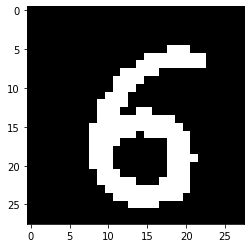



Final Output: 6

Prediction (Softmax) from the neural network:

 [[9.7763068e-11 7.5055039e-13 4.3249781e-13 1.9642620e-15 1.9884637e-14
  6.5297983e-04 9.9934703e-01 4.0434259e-18 2.5204690e-08 1.6329889e-09]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




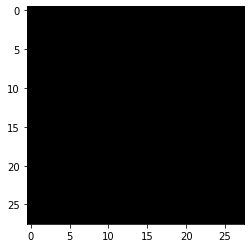



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




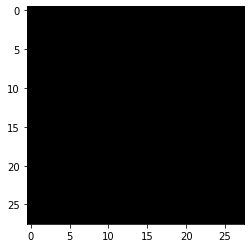



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




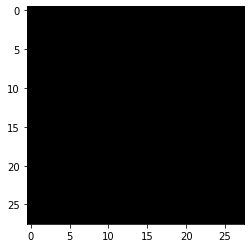



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




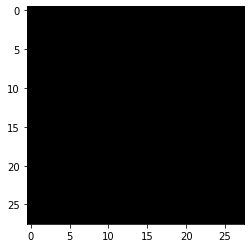



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




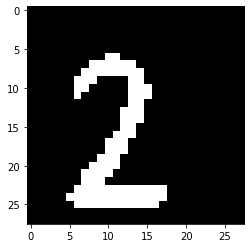



Final Output: 2

Prediction (Softmax) from the neural network:

 [[1.5484513e-11 6.8321740e-03 9.9316204e-01 5.7138677e-06 1.6363720e-13
  4.7154685e-13 1.1531848e-12 6.8741222e-08 7.2517756e-11 2.9406451e-09]]


Hard-maxed form of the prediction: 

 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




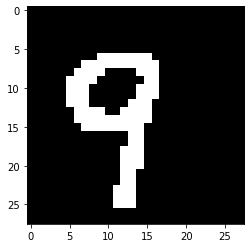



Final Output: 9

Prediction (Softmax) from the neural network:

 [[1.4079082e-10 3.3229793e-05 2.7469093e-06 1.5566168e-06 1.7852827e-08
  4.6319983e-07 1.3029494e-10 1.5803718e-04 4.2664295e-01 5.7316101e-01]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




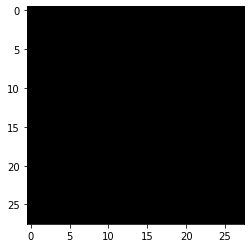



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




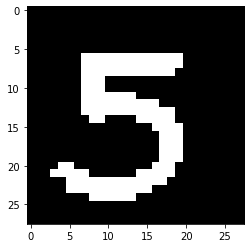



Final Output: 5

Prediction (Softmax) from the neural network:

 [[5.1791788e-18 2.3351513e-18 4.4874383e-19 2.1773146e-03 3.7115677e-13
  9.9782276e-01 3.1203277e-15 6.1131353e-09 8.9576330e-10 4.0734509e-14]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




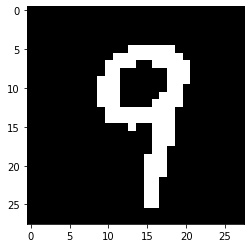



Final Output: 9

Prediction (Softmax) from the neural network:

 [[1.8487434e-08 1.6794508e-09 2.3084976e-10 1.6288014e-09 2.1861435e-03
  5.7031129e-06 2.2427683e-12 1.3367475e-03 8.0042556e-03 9.8846722e-01]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




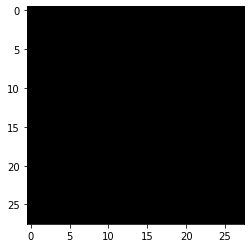



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




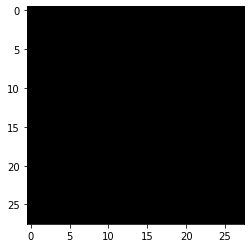



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




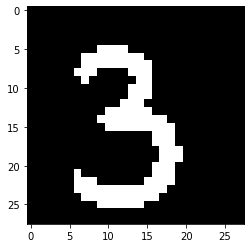



Final Output: 3

Prediction (Softmax) from the neural network:

 [[7.9777756e-16 3.6609778e-21 1.3402533e-14 1.0000000e+00 1.9516235e-14
  6.6839743e-09 8.6069638e-17 1.6552941e-15 9.4257380e-12 2.2039315e-12]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




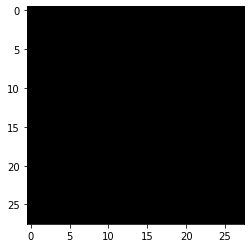



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




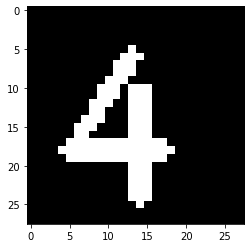



Final Output: 6

Prediction (Softmax) from the neural network:

 [[7.5107282e-06 1.7408833e-04 2.3385610e-03 1.3354204e-10 6.5810182e-03
  1.3768146e-02 9.7294128e-01 4.1775382e-03 2.0605090e-07 1.1755160e-05]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




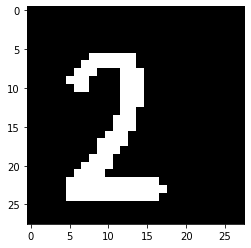



Final Output: 2

Prediction (Softmax) from the neural network:

 [[8.8223873e-10 1.3018480e-03 9.9869436e-01 2.0423063e-06 9.9318002e-12
  4.6922938e-11 5.5107828e-12 1.5494078e-06 2.8165405e-07 5.0916737e-09]]


Hard-maxed form of the prediction: 

 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




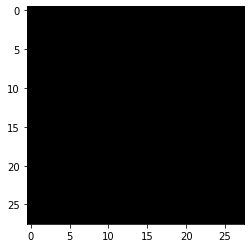



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




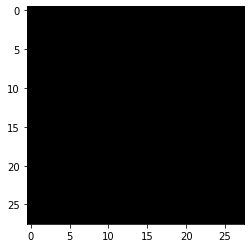



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




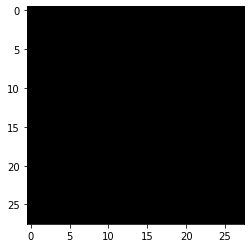



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




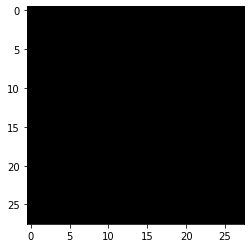



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




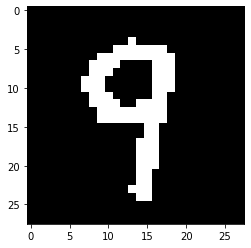



Final Output: 4

Prediction (Softmax) from the neural network:

 [[2.1562127e-12 3.8648494e-05 1.1814437e-07 5.6045057e-08 9.6662581e-01
  2.0725116e-11 4.6162834e-15 6.8532941e-08 3.9242295e-04 3.2942791e-02]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




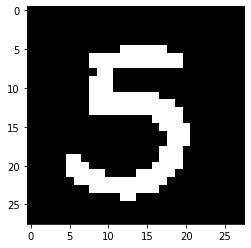



Final Output: 5

Prediction (Softmax) from the neural network:

 [[5.88661325e-12 4.79688257e-21 1.05065537e-16 5.32883108e-02
  1.40546169e-14 9.46711421e-01 1.03806237e-16 1.82984364e-10
  1.19246113e-10 2.93418736e-07]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




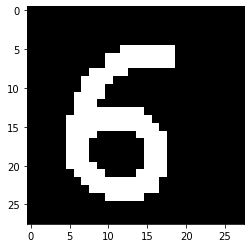



Final Output: 5

Prediction (Softmax) from the neural network:

 [[1.4496774e-06 6.1226032e-15 1.0195109e-09 1.9369082e-08 8.4805709e-15
  9.9999475e-01 3.5917142e-06 1.4010650e-12 1.9723895e-07 8.5422946e-11]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




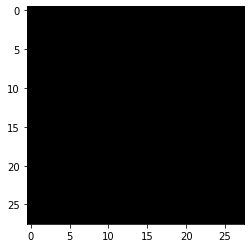



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




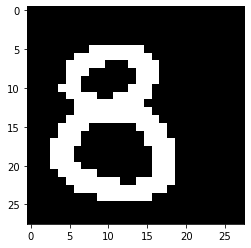



Final Output: 3

Prediction (Softmax) from the neural network:

 [[2.5732929e-08 4.1594553e-12 1.2731596e-06 9.9992180e-01 1.3022942e-08
  7.6900025e-05 5.0261175e-17 3.6890050e-08 1.0968216e-08 9.6527941e-09]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




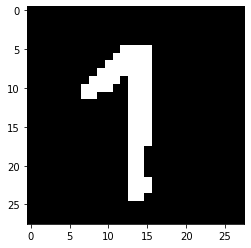



Final Output: 1

Prediction (Softmax) from the neural network:

 [[1.03355629e-14 9.99977469e-01 4.18013152e-10 7.48593409e-11
  4.69266188e-11 8.99800474e-15 2.29756738e-14 2.25787953e-05
  3.69879771e-09 1.13718705e-11]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




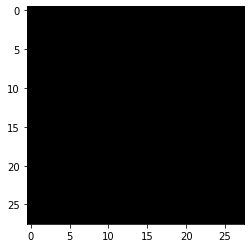



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




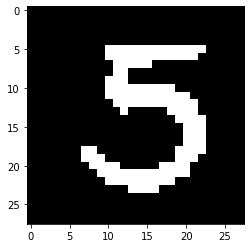



Final Output: 5

Prediction (Softmax) from the neural network:

 [[5.1728991e-04 6.3622545e-12 3.5405451e-13 1.4557529e-09 5.6062102e-14
  9.9948263e-01 4.2897205e-12 1.0806975e-09 1.1252553e-13 3.0032981e-09]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




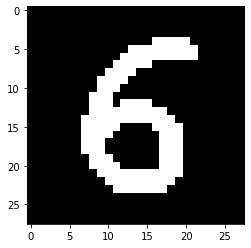



Final Output: 6

Prediction (Softmax) from the neural network:

 [[9.6826869e-10 1.4932740e-19 2.5318687e-15 2.1299834e-14 3.3474544e-17
  1.6411883e-05 9.9998355e-01 1.4612498e-19 4.6873971e-10 1.6104963e-11]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




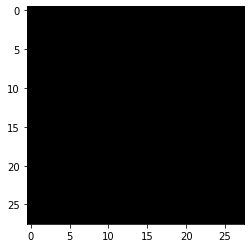



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




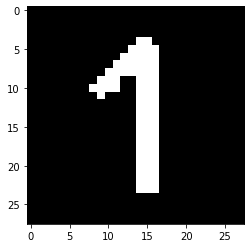



Final Output: 1

Prediction (Softmax) from the neural network:

 [[1.4968508e-12 9.9986994e-01 1.2567702e-07 4.3783789e-11 1.9362369e-09
  1.6560747e-10 8.2174788e-12 1.2997714e-04 6.1581945e-10 4.3008392e-08]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




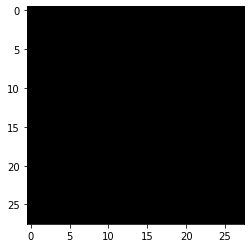



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




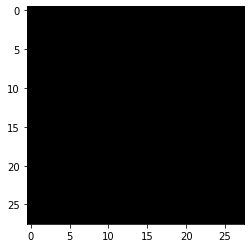



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




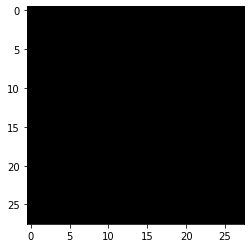



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




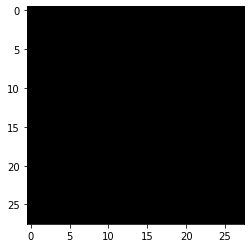



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




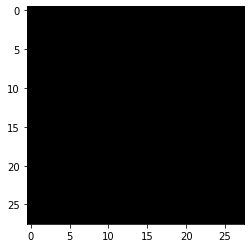



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




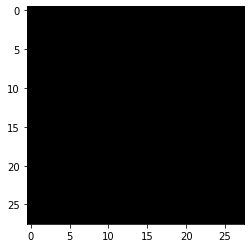



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




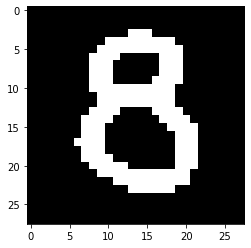



Final Output: 0

Prediction (Softmax) from the neural network:

 [[9.9954730e-01 1.3178148e-16 5.5403751e-11 7.1192530e-10 5.0712726e-11
  4.5260609e-04 7.5831251e-12 3.3915953e-13 6.1664146e-08 1.2983095e-09]]


Hard-maxed form of the prediction: 

 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




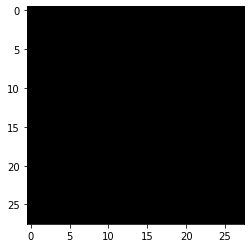



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




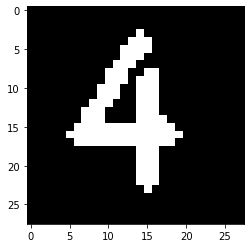



Final Output: 4

Prediction (Softmax) from the neural network:

 [[4.6814209e-11 1.3731232e-09 6.8702427e-12 7.6805867e-11 9.9999952e-01
  3.6265269e-09 3.0944356e-08 1.3291979e-08 1.0856416e-09 5.1066985e-07]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




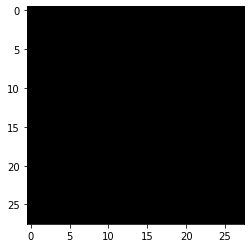



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




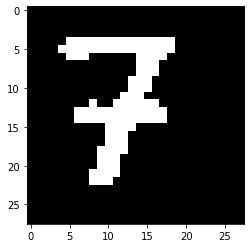



Final Output: 2

Prediction (Softmax) from the neural network:

 [[3.5793276e-12 4.7377107e-05 9.9980766e-01 1.3501360e-04 7.0125975e-06
  6.5235938e-08 2.7897222e-06 2.7161089e-09 3.5940435e-08 3.4154807e-10]]


Hard-maxed form of the prediction: 

 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




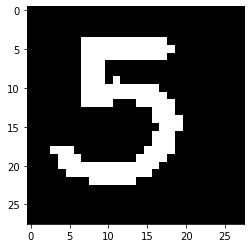



Final Output: 5

Prediction (Softmax) from the neural network:

 [[1.6685878e-15 2.7648363e-17 8.3405300e-09 1.2943248e-02 5.5061142e-12
  9.8705673e-01 7.4488282e-10 4.6807037e-12 2.8827591e-11 3.4195903e-14]]


Hard-maxed form of the prediction: 

 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




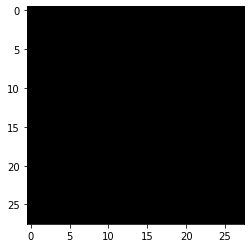



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




---------------------------------------


=========PREDICTION============ 




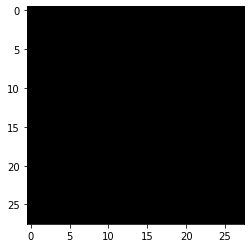



Final Output: 1

Prediction (Softmax) from the neural network:

 [[0.10119894 0.10824241 0.10077841 0.0987186  0.09797864 0.09719891
  0.09935085 0.09984265 0.09761291 0.09907771]]


Hard-maxed form of the prediction: 

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---------------------------------------




In [187]:
for digit in cells:
    prediction = model.predict(digit.reshape(1, 28, 28, 1))  
    
    print ("\n\n---------------------------------------\n\n")
    print ("=========PREDICTION============ \n\n")
    plt.imshow(digit.reshape(28, 28), cmap="gray")
    plt.show()
    print("\n\nFinal Output: {}".format(np.argmax(prediction)))
    
    print ("\nPrediction (Softmax) from the neural network:\n\n {}".format(prediction))
    
    hard_maxed_prediction = np.zeros(prediction.shape)
    hard_maxed_prediction[0][np.argmax(prediction)] = 1
    print ("\n\nHard-maxed form of the prediction: \n\n {}".format(hard_maxed_prediction))
    print ("\n\n---------------------------------------\n\n")

[array([[-1,  6, -1, -1, -1, -1,  2, -1, -1],
        [ 4, -1, -1,  0,  2, -1, -1,  0,  3],
        [ 3, -1,  4,  4,  2, -1,  6, -1,  2],
        [-1,  3, -1,  2, -1, -1,  4, -1, -1],
        [-1, -1,  3,  4, -1, -1,  2,  5, -1],
        [-1,  5,  0, -1, -1, -1, -1, -1,  6],
        [-1, -1,  2, -1, -1, -1, -1, -1,  4],
        [ 4,  2,  4, -1, -1,  3,  0,  6, -1],
        [-1, -1, -1,  4, -1,  6,  2, -1,  5]], dtype=int16)]

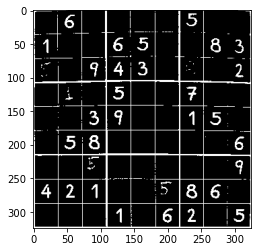

In [228]:
res = []

for digit in cells:
    prediction = model.predict(digit.reshape(1, 28, 28, 1)) 
    if (max(sum(prediction)))<0.5:
        res.append(-1)
    else:
        res.append(np.argmax(prediction))

    
    
l1=[]
l2 = []
l3 = []
l4 =[]
l5= []
l6 =[]
l7 =[]
l8 = []
l9 =[]
for i in range(81):
    if i//9==0:
        l1.append(res[i])
    if i//9==1:
        l2.append(res[i])
    if i//9==2:
        l3.append(res[i])
    if i//9==3:
        l4.append(res[i])
    if i//9==4:
        l5.append(res[i])
    if i//9==5:
        l6.append(res[i])
    if i//9==6:
        l7.append(res[i])
    if i//9==7:
        l8.append(res[i])
    if i//9==8:
        l9.append(res[i])

cell_res = [l1, l2, l3, l4, l5, l6, l7, l8, l9]

        
plt.imshow(bw_img, cmap=plt.cm.gray)
cell_res = [np.int16(cell_res),]
cell_res

# повысить трешхолд (там где карандашем не читает)

# чтобы две доски считал

# настройка самой нейронки

# поворот - чтобы всегда ориентировка норм ( а не в ручную)

In [142]:
import joblib
import numpy as np
from mnist import MNIST
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from sklearn import preprocessing
from collections import Counter

save_model_path = "."
MNIST_CELL_SIZE = 28

mnist_data_path = '.'
mnist_data = MNIST(mnist_data_path)
mnist_data.gz = True

images_train, labels_train = mnist_data.load_training()
images_test, labels_test = mnist_data.load_testing()

images_train = np.uint8([np.reshape(im, (MNIST_CELL_SIZE,) * 2) for im in images_train])
images_test = np.uint8([np.reshape(im, (MNIST_CELL_SIZE,) * 2) for im in images_test])
labels_train, labels_test = np.int16(labels_train), np.int16(labels_test)

# EXAMPLE OF TRAINING RandomForest
#features_train = np.array([im.ravel() for im in images_train])
#features_test = np.array([im.ravel() for im in images_test])

list_hog = []
for feature in images_train:
    fd = hog(feature.reshape((28,28)), orientations=9, pixels_per_cell=(14,14),cells_per_block=(1,1) )
    list_hog.append(fd)
    
hog_features_train = np.array(list_hog, dtype='float64')

preProcess_train = preprocessing.MaxAbsScaler().fit(hog_features_train)
hog_features_transformed_train = preProcess_train.transform(hog_features_train)

list_hog = []
for feature in images_test:
    fd = hog(feature.reshape((28,28)), orientations=9, pixels_per_cell=(14,14),cells_per_block=(1,1) )
    list_hog.append(fd)
    
hog_features_test = np.array(list_hog, 'float64')

preProcess_test = preprocessing.MaxAbsScaler().fit(hog_features_test)
hog_features_transformed_test = preProcess_test.transform(hog_features_test)

#from sklearn.model_selection import train_test_split
#from sklearn.neural_network import MLPClassifier
#X_train, X_test, y_train, y_test = train_test_split(hog_features_transformed,target , random_state = 0)
#Model = Model = MLPClassifier(activation='relu', hidden_layer_sizes=(200, 200), alpha = 0.3)
#Model.fit(hog_features_transformed_train, labels_train)
#print('Training Score :: {}\n'.format(Model.score(hog_features_transformed_train, labels_train)))
#print('Testing Score :: {}\n'.format(Model.score(hog_features_transformed_test, labels_test)))

rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf.fit(hog_features_transformed_train, labels_train)

# SAVING MODEL !!!
# joblib.dump(rf, save_model_path)
# joblib.load()

print_accuracy = True

if print_accuracy:
    from sklearn.metrics import accuracy_score
    print(accuracy_score(labels_test, Model.predict(hog_features_transformed_test)))




0.8958


In [146]:
list_hog = []
for feature in cells:
    feature = feature
    fd = hog(feature.reshape((28,28)), orientations=9, pixels_per_cell=(14,14),cells_per_block=(1,1) )
    list_hog.append(fd)
    
cells_hog = np.array(list_hog, 'float64')

res = Model.predict(cells_hog)
res

array([1, 1, 5, 7, 1, 7, 7, 7, 1, 1, 1, 1, 1, 1, 5, 7, 1, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 5, 1, 1, 1, 1, 1, 7, 1,
       5, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 5, 5, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1], dtype=int16)

[[1, 1, 5, 7, 1, 7, 7, 7, 1],
 [1, 1, 1, 1, 1, 5, 7, 1, 3],
 [1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 5, 1, 1, 1],
 [5, 1, 1, 1, 1, 1, 7, 1, 5],
 [4, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 5, 1, 1, 1, 1, 1],
 [5, 5, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 7, 1, 1]]

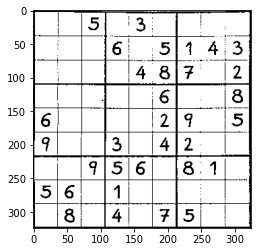

In [147]:
l1=[]
l2 = []
l3 = []
l4 =[]
l5= []
l6 =[]
l7 =[]
l8 = []
l9 =[]
for i in range(81):
    if i//9==0:
        l1.append(res[i])
    if i//9==1:
        l2.append(res[i])
    if i//9==2:
        l3.append(res[i])
    if i//9==3:
        l4.append(res[i])
    if i//9==4:
        l5.append(res[i])
    if i//9==5:
        l6.append(res[i])
    if i//9==6:
        l7.append(res[i])
    if i//9==7:
        l8.append(res[i])
    if i//9==8:
        l9.append(res[i])

cell_res = [l1, l2, l3, l4, l5, l6, l7, l8, l9]

        
plt.imshow(bw_img, cmap=plt.cm.gray)
cell_res

In [119]:
cn = 0
for i in cells:
    if np.mean(i) >230:
        res[cn] = -1
    cn+=1
    
res

array([-1, -1,  1, -1,  7,  7, -1, -1,  7, -1, -1, -1,  7, -1,  4, -1,  1,
        4, -1, -1, -1, -1,  1,  4,  1, -1,  1,  7, -1,  1,  1, -1,  7, -1,
       -1,  4,  7, -1,  1, -1, -1,  1, -1, -1,  4,  0, -1, -1,  4, -1,  1,
        4, -1, -1,  1,  1,  4,  5,  7,  7,  2,  1,  7,  0,  7, -1,  1, -1,
        7, -1, -1, -1, -1,  4, -1,  1, -1,  1,  0, -1,  1], dtype=int16)

[[-1, -1, 1, -1, 7, 7, -1, -1, 7],
 [-1, -1, -1, 7, -1, 4, -1, 1, 4],
 [-1, -1, -1, -1, 1, 4, 1, -1, 1],
 [7, -1, 1, 1, -1, 7, -1, -1, 4],
 [7, -1, 1, -1, -1, 1, -1, -1, 4],
 [0, -1, -1, 4, -1, 1, 4, -1, -1],
 [1, 1, 4, 5, 7, 7, 2, 1, 7],
 [0, 7, -1, 1, -1, 7, -1, -1, -1],
 [-1, 4, -1, 1, -1, 1, 0, -1, 1]]

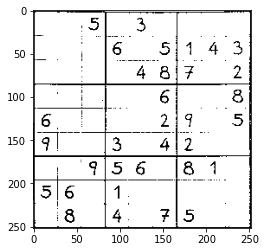

In [122]:
l1=[]
l2 = []
l3 = []
l4 =[]
l5= []
l6 =[]
l7 =[]
l8 = []
l9 =[]
for i in range(81):
    if i//9==0:
        l1.append(res[i])
    if i//9==1:
        l2.append(res[i])
    if i//9==2:
        l3.append(res[i])
    if i//9==3:
        l4.append(res[i])
    if i//9==4:
        l5.append(res[i])
    if i//9==5:
        l6.append(res[i])
    if i//9==6:
        l7.append(res[i])
    if i//9==7:
        l8.append(res[i])
    if i//9==8:
        l9.append(res[i])

cell_res = [l1, l2, l3, l4, l5, l6, l7, l8, l9]

        
plt.imshow(bw_img, cmap=plt.cm.gray)
cell_res

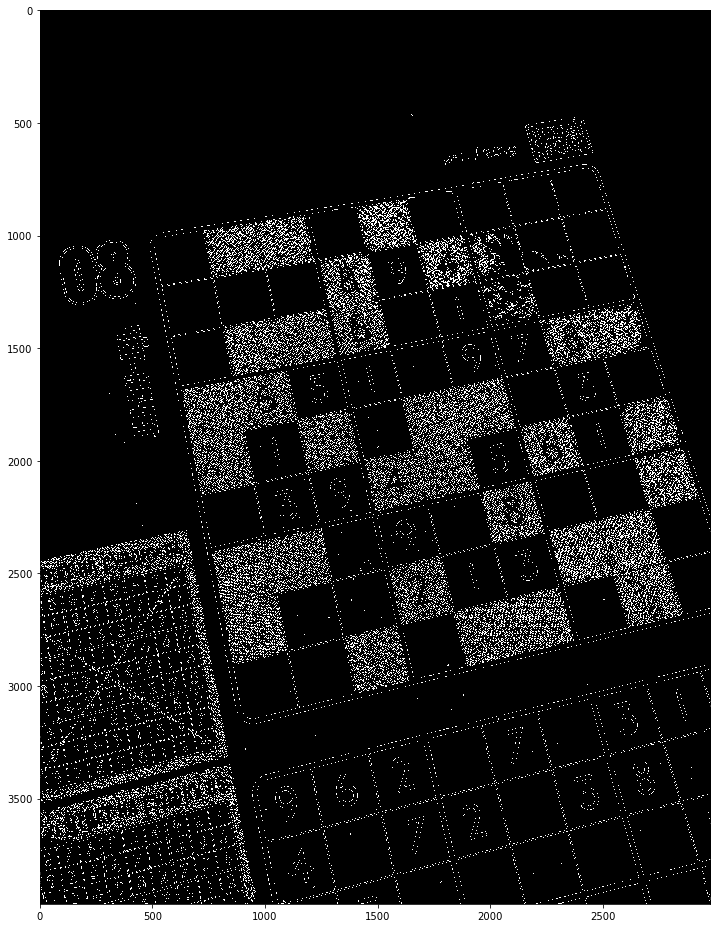

In [10]:
from skimage.transform import rescale
#image_scaled = rescale(img, 0.3, multichannel=False)
edges = canny(img,
              sigma=0.3,
              low_threshold=0.3*np.mean(img),
              high_threshold=1*np.mean(img))
plt.figure(figsize=(13, 13))
io.imshow(edges)

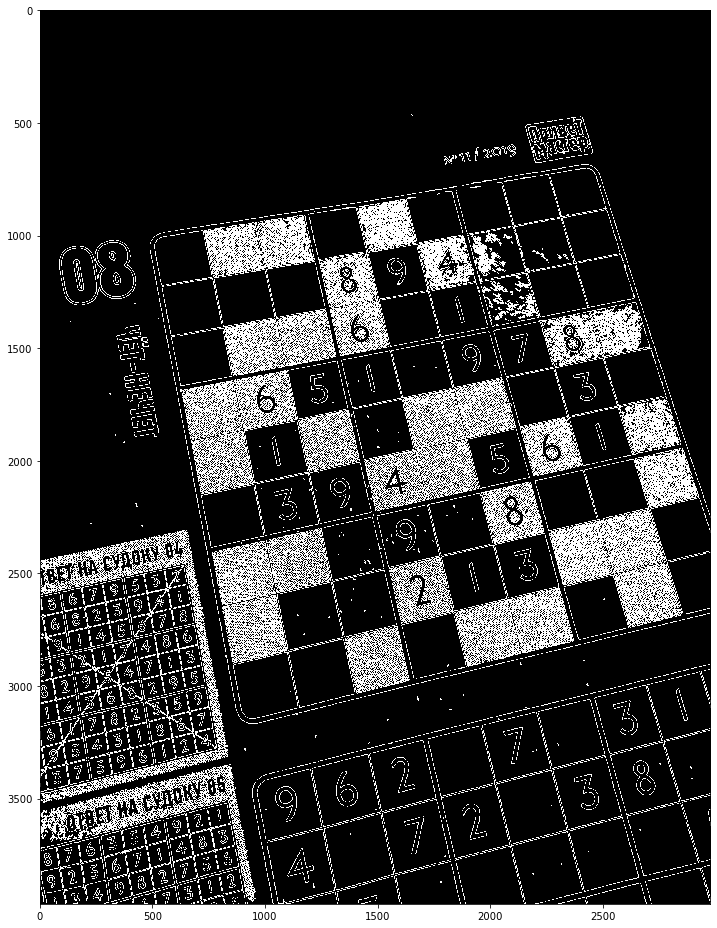

In [4]:
from skimage.morphology import dilation, disk

selem = disk(1)
edges = dilation(edges, selem)
plt.figure(figsize=(13, 13))
io.imshow(edges)

In [155]:
import joblib
import numpy as np
from mnist import MNIST
from sklearn.ensemble import RandomForestClassifier

save_model_path = "."
MNIST_CELL_SIZE = 28

mnist_data_path = '.'
mnist_data = MNIST(mnist_data_path)
mnist_data.gz = True

images_train, labels_train = mnist_data.load_training()
images_test, labels_test = mnist_data.load_testing()

images_train = np.uint8([np.reshape(im, (MNIST_CELL_SIZE,) * 2) for im in images_train])
images_test = np.uint8([np.reshape(im, (MNIST_CELL_SIZE,) * 2) for im in images_test])
labels_train, labels_test = np.int16(labels_train), np.int16(labels_test)

# EXAMPLE OF TRAINING RandomForest
features_train = np.array([im.ravel() for im in images_train])
features_test = np.array([im.ravel() for im in images_test])
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf.fit(features_train, labels_train)

# SAVING MODEL !!!
# joblib.dump(rf, save_model_path)
# joblib.load()

print_accuracy = True

if print_accuracy:
    from sklearn.metrics import accuracy_score
    print(accuracy_score(labels_test, rf.predict(features_test)))

0.9705


In [157]:
features_sud = np.array([im.ravel() for im in cells])
res = rf.predict(features_sud)
res

array([0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 3, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 6, 3, 0, 2, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0], dtype=int16)

[[0, 0, 6, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 3, 0, 3, 0, 3, 0],
 [0, 0, 0, 0, 0, 3, 0, 0, 0],
 [0, 0, 0, 0, 0, 3, 0, 0, 2],
 [6, 0, 0, 0, 0, 0, 0, 0, 2],
 [0, 0, 0, 0, 0, 3, 0, 0, 0],
 [0, 0, 0, 6, 3, 0, 2, 0, 0],
 [2, 2, 0, 0, 0, 0, 0, 0, 0],
 [0, 2, 0, 0, 0, 2, 2, 0, 0]]

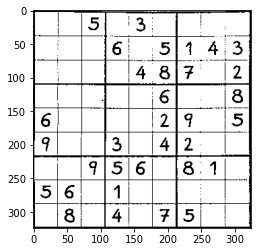

In [158]:
l1=[]
l2 = []
l3 = []
l4 =[]
l5= []
l6 =[]
l7 =[]
l8 = []
l9 =[]
for i in range(81):
    if i//9==0:
        l1.append(res[i])
    if i//9==1:
        l2.append(res[i])
    if i//9==2:
        l3.append(res[i])
    if i//9==3:
        l4.append(res[i])
    if i//9==4:
        l5.append(res[i])
    if i//9==5:
        l6.append(res[i])
    if i//9==6:
        l7.append(res[i])
    if i//9==7:
        l8.append(res[i])
    if i//9==8:
        l9.append(res[i])

cell_res = [l1, l2, l3, l4, l5, l6, l7, l8, l9]

        
plt.imshow(bw_img, cmap=plt.cm.gray)
cell_res

In [14]:
features_sud[1]

array([0.33542959, 0.32914286, 0.34439909, 0.31268882, 0.34400151,
       0.31853706, 0.27989756, 0.26958487, 0.28784449, 0.2811499 ,
       0.29219665, 0.24964955, 0.30075757, 0.30868258, 0.28206314,
       0.27391604, 0.28484666, 0.30466165, 0.23344495, 0.22446554,
       0.23209364, 0.22967936, 0.21760113, 0.22661082, 0.23563917,
       0.27653282, 0.2251381 , 0.18687315, 0.49687145, 0.48627451,
       0.47843137, 0.50109236, 0.4907237 , 0.5096269 , 0.50196078,
       0.50196078, 0.49411765, 0.49403324, 0.49411765, 0.50298495,
       0.51718917, 0.49411765, 0.49411765, 0.5028188 , 0.49411765,
       0.48564104, 0.49023582, 0.49733798, 0.48777401, 0.49411765,
       0.49766128, 0.49411765, 0.49411765, 0.49237875, 0.47957385,
       0.4502724 , 0.51839695, 0.48647426, 0.48781416, 0.49632182,
       0.50196078, 0.50196078, 0.49734756, 0.50196078, 0.49411765,
       0.49411765, 0.49411765, 0.49063879, 0.49927691, 0.50196078,
       0.50196078, 0.49411765, 0.49805071, 0.49411765, 0.49411

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(features_train, labels_train)
print(accuracy_score(labels_test, neigh.predict(features_test)))

In [1]:
from sklearn import datasets, svm, metrics

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
#X_train, X_test, y_train, y_test = train_test_split(
#    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(features_train, labels_train)

# Now predict the value of the digit on the second half:
#predicted = classifier.predict(X_test)
print(accuracy_score(labels_test, classifier.predict(features_test)))

NameError: name 'features_train' is not defined

In [ ]:
import math
cdst = dst.copy()
lines = cv.HoughLines(dst, 1, np.pi / 200, 150, None, 0, 0)
# Draw the lines
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv.line(cdst, pt1, pt2, (0,0,255), 3, cv.LINE_AA)


In [30]:
# Probabilistic Line Transform
linesP = cv.HoughLinesP(dst, 1, np.pi / 180, 50, None, 50, 10)

In [31]:
# Draw the lines
cdstP = dst.copy()
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)

In [32]:
# Show results
cv.imshow("Source", dst)
cv.imshow("Detected Lines (in red) - Standard Hough Line Transform", cdst)
cv.imshow("Detected Lines (in red) - Probabilistic Line Transform", cdstP)

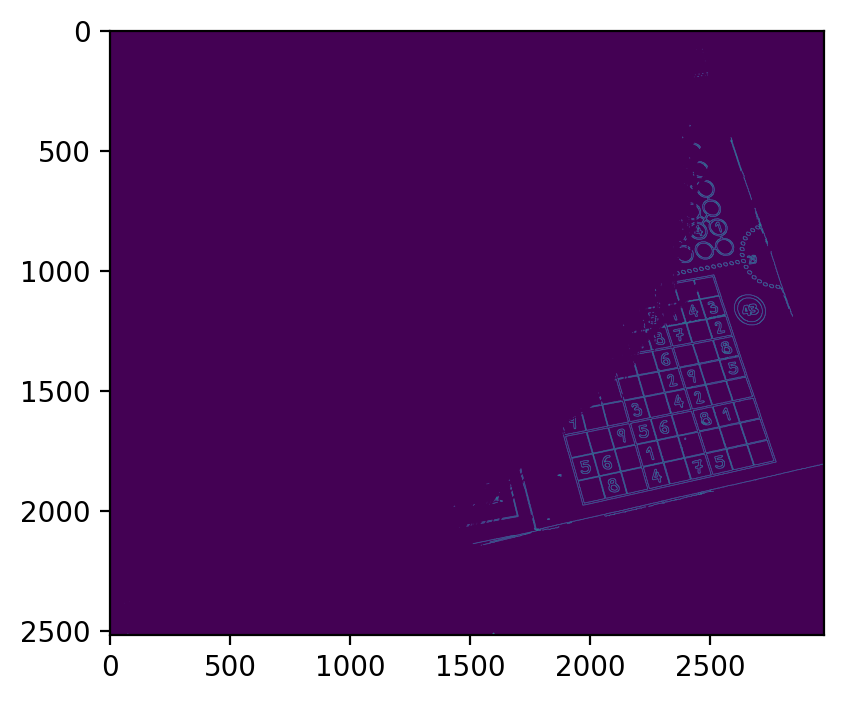

In [33]:
plt.figure(dpi=200)
plt.imshow(cdst)

Grading.
Sudoku 9x9 tables segmentation. The output is binary masks of the same size with the original image. (45% points based on IoU). IoU > 0.9 will be considered as 1.0, since the Ground Truth masks are not perfectly annotated.
Digit recognizer. The output is list with 9x9 arrays with digits (including empty cells as specified symbol). (45% points based on Accuracy).
Classifier training function. It is separate function to obtain the same model, you've uploaded in Gradescope. (10% points, manually graded)
Complete algorithm: filled solution of sudoku. (Extra 20% points, manually graded)
The final score will be scaled into 20 hw points, including bonus points from [4.] (100 gradescope points = 20 canvas points).

Be aware, that platform automatically performs pretty smart code similarity comparison. Share your solutions on your own risk of loosing homework scores:)

If you apparently find any security leaks, exploit them on your own risk of loosing homework scores:)

[[[ 28  24]]

 [[ 27  25]]

 [[ 26  25]]

 ...

 [[153  25]]

 [[150  25]]

 [[149  24]]]
(1477, 1, 2)
(1477, 2)


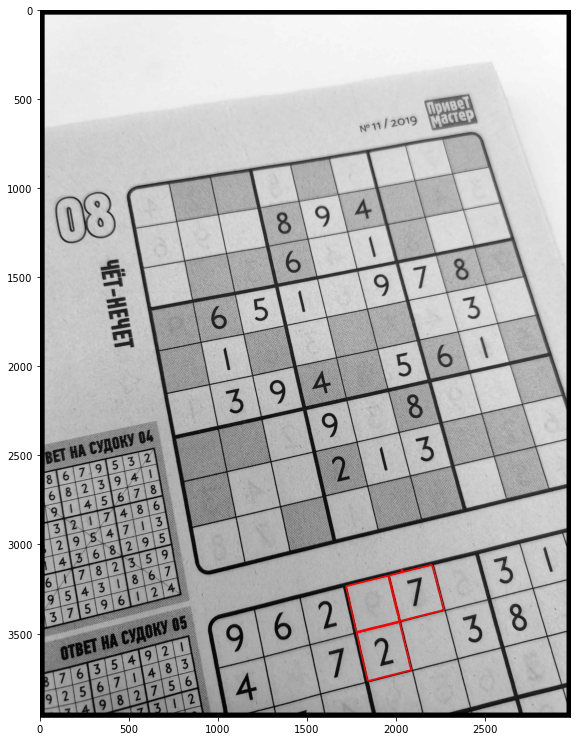

In [238]:
contour = max(ext_contours, key= lambda x : cv.contourArea(x))
print(contour)
# we need to remove one unnecessary dimension
print(secCont.shape)
secCont = secCont.squeeze()
print(secCont.shape)
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(secCont[:, 0], secCont[:,  1], 'r')

In [235]:
areas = []
for i in range(len(ext_contours)):
    areas.append(cv.contourArea(ext_contours[i]))
 
print(areas)
result = np.where(areas ==np.sort(areas)[-2])
result = int(result[0][0])
secCont = ext_contours[result]
print(secCont)

[100.0, 1959.5, 10399.0, 17757.5, 27075.0, 28296.0, 35276.5, 52794.5, 70801.5, 90008.5, 24.5, 69537.0, 73766.5, 81764.0, 69425.0, 70109.5, 140814.0, 67497.5, 67545.0, 69318.0, 65844.5, 128052.5, 50759.5, 200606.5, 79458.0, 62980.0, 33.0, 77311.0, 36428.0, 76938.0, 75047.0, 23312.5, 74378.0, 72438.5, 9206418.5]
[[[2195 3115]]

 [[2194 3116]]

 [[2192 3116]]

 ...

 [[2202 3118]]

 [[2202 3116]]

 [[2201 3115]]]


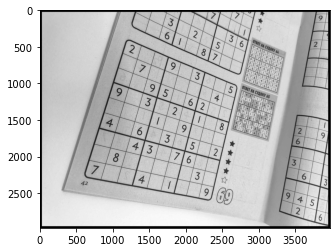

In [4]:
h,w=img.shape[0:2]
cv.rectangle(img,(0,0),(w,h),(0,255,0),50)
plt.imshow(img, cmap=plt.cm.gray)

Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      0.97      0.98        91
           2       0.99      0.99      0.99        86
           3       0.98      0.87      0.92        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      0.99      0.99        91
           7       0.96      0.99      0.97        89
           8       0.94      1.00      0.97        88
           9       0.93      0.98      0.95        92

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899


Confusion matrix:
[[87  0  0  0  1  0  0  0  0  0]
 [ 0 88  1  0  0  0  0  0  1  1]
 [ 0  0 85  1  0  0  0  0  0  0]
 [ 0  0  0 79  0  3  0  4  5  0]
 [ 0  0  0  0 88  0  0  0  0  4]
 [

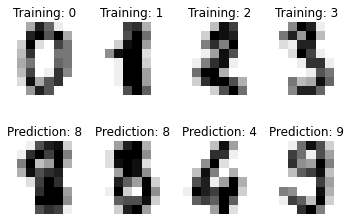

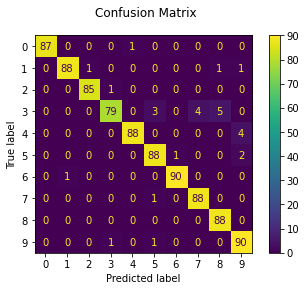

In [25]:

# Author: Gael Varoquaux <gael dot varoquaux at normalesup dot org>
# License: BSD 3 clause

# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

In [27]:
!pip install torch

  Running setup.py clean for torch
Failed to build torch
    Running setup.py install for torch: started
    Running setup.py install for torch: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\admin\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\admin\\AppData\\Local\\Temp\\pip-install-yy9vevyz\\torch\\setup.py'"'"'; __file__='"'"'C:\\Users\\admin\\AppData\\Local\\Temp\\pip-install-yy9vevyz\\torch\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\admin\AppData\Local\Temp\pip-wheel-c7f7wk7l'
       cwd: C:\Users\admin\AppData\Local\Temp\pip-install-yy9vevyz\torch\
  Complete output (30 lines):
  running bdist_wheel
  running build
  running build_deps
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "C:\Users\admin\AppData\Local\Temp\pip-install-yy9vevyz\torch\setup.py", line 225, in <module>
      setup(name="torch", version="0.1.2.post2",
    File "C:\Users\admin\anaconda3\

In [30]:
import joblib
import random

#import torch
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# pip install python-mnist
from mnist import MNIST
# download 4 MNIST files you can here:
# http://yann.lecun.com/exdb/mnist/


MNIST_CELL_SIZE = 28
SEED = 0xBadCafe


def fix_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def train(save_model_path='random_forest.joblib', mnist_data_path='mnist_data', print_accuracy=False):

    # FIXING RANDOM SEED:
    fix_seed(SEED)

    # EXAMPLE OF LOADING MNIST
    mnist_data = MNIST(mnist_data_path)
    mnist_data.gz = True

    images_train, labels_train = mnist_data.load_training()
    images_test, labels_test = mnist_data.load_testing()

    images_train = np.uint8([np.reshape(im, (MNIST_CELL_SIZE,) * 2) for im in images_train])
    images_test = np.uint8([np.reshape(im, (MNIST_CELL_SIZE,) * 2) for im in images_test])
    labels_train, labels_test = np.int16(labels_train), np.int16(labels_test)

    # EXAMPLE OF TRAINING RandomForest

    # hog = get_hog()  # from cv2
    # features_train = np.array([hog.compute(im).T[0] for im in images_train])
    # features_test = np.array([hog.compute(im).T[0] for im in images_test])
    features_train = np.array([im.ravel() for im in images_train])
    features_test = np.array([im.ravel() for im in images_test])

    rf = RandomForestClassifier(n_jobs=-1, random_state=SEED)
    rf.fit(features_train, labels_train)

    # SAVING MODEL !!!
    joblib.dump(rf, save_model_path)
    joblib.load()

    if print_accuracy:
        from sklearn.metrics import accuracy_score
        print(accuracy_score(labels_test, rf.predict(features_test)))


ImportError: cannot import name 'MNIST' from 'mnist' (C:\Users\admin\anaconda3\lib\site-packages\mnist\__init__.py)

In [37]:
pip uninstall mnist


^C
Note: you may need to restart the kernel to use updated packages.
